# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-и-обзор-данных" data-toc-modified-id="Вывод-и-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод и обзор данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Использование-простых-моделей" data-toc-modified-id="Использование-простых-моделей-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Использование простых моделей</a></span><ul class="toc-item"><li><span><a href="#Работа-с-LinearRegression" data-toc-modified-id="Работа-с-LinearRegression-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Работа с LinearRegression</a></span></li><li><span><a href="#Работа-с-RandomForestRegressor" data-toc-modified-id="Работа-с-RandomForestRegressor-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Работа с RandomForestRegressor</a></span></li><li><span><a href="#Работа-с-DecisionTreeRegressor" data-toc-modified-id="Работа-с-DecisionTreeRegressor-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Работа с DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Использование-градиентного-бустинга(библиотека-LightGBM)" data-toc-modified-id="Использование-градиентного-бустинга(библиотека-LightGBM)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Использование градиентного бустинга(библиотека LightGBM)</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Сравнение-характеристик-моделей:-скорость-работы(%%time),-точность-результата(метрика-RMSE)" data-toc-modified-id="Сравнение-характеристик-моделей:-скорость-работы(%%time),-точность-результата(метрика-RMSE)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Сравнение характеристик моделей: скорость работы(%%time), точность результата(метрика RMSE)</a></span></li></ul></li></ul></div>

## Подготовка данных

conda install -c conda-forge lightgbm

In [4]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('C:/Users/fokin/OneDrive/Рабочий стол/Дата Сайнс/Численные методы/Проект/autos.csv')

In [5]:
# рассмотрим информацию
display(data.info())
display(data.columns)
display(data.describe())
display(data.head(10))
display(data.tail(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


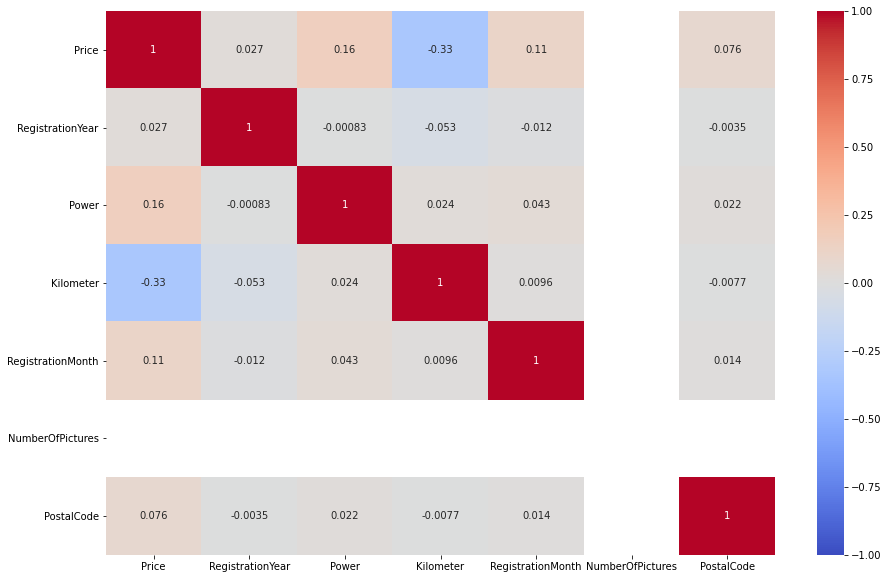

In [6]:
# проверим корреляции признаков получившегося датасета
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

В данном блоке данные/признаки датасета были предварительно проверены на мультиколлинеарность и было рассмотрено влияние на целевой признак, при проверке корреляций выявили- мультиколлинеарности нет, влияние признаков друг на друга слабое и очень слабое:
- registration_year: корреляция 0.027 - очень слабая положительная, влияние признака на целевой очень слабое,
- power: корреляция 0.16 - слабая положительная, влияние признака на целевой слабое,
- kilometer: корреляция -0.33 - слабая отрицательная, влияние признака на целевой слабое,
- registration_month: корреляция 0.11 - очень слабая положительная, влияние признака на целевой очень слабое.

In [7]:
# исправим названия столбцов на более удобные в змеином стиле
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
display(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [8]:
# удалим найденные дубликаты на начальном этапе
display(data.duplicated().sum())
display(data[data.duplicated() == True])
data = data.drop_duplicates().reset_index(drop = True)
display(data.duplicated().sum())
display(data.info())

4

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  not_repaired        283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

None

In [9]:
# рассмотрим пропуски
display(data.isna().sum())

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [10]:
# проанализируем уникальные варианты заполнения в данных, где есть пропуски
display(data.groupby('vehicle_type')['vehicle_type'].count().sort_values(ascending=False))
display(data.groupby('gearbox')['gearbox'].count().sort_values(ascending=False))
display(data.groupby('model')['model'].count().sort_values(ascending=False))
display(data.groupby('fuel_type')['fuel_type'].count().sort_values(ascending=False))
display(data.groupby('not_repaired')['not_repaired'].count().sort_values(ascending=False))

vehicle_type
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

gearbox
manual    268249
auto       66283
Name: gearbox, dtype: int64

model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
astra                 10809
passat                10145
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ibiza                  2702
ka                     2702
lupo                   2594
octavia                2108
fabia                  2080
cooper                 1950
clk           

fuel_type
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

not_repaired
no     247158
yes     36053
Name: not_repaired, dtype: int64

In [11]:
# признак not_repaired не может быть связан со всеми остальными признаками и
# будет зависеть от характера использования автомобиля, поэтому пропуски заменим на unknown
data['not_repaired'] = data['not_repaired'].fillna('unknown')
display(data.groupby('not_repaired')['not_repaired'].count().sort_values(ascending=False))

not_repaired
no         247158
unknown     71154
yes         36053
Name: not_repaired, dtype: int64

In [12]:
# определим зависимость от признака model признаков vehicle_type, gearbox, fuel_type
vehicle_type_by_model = data.pivot_table(index='model', columns='vehicle_type', values='price' , aggfunc='count', fill_value=0)
vehicle_type_by_model = pd.DataFrame(data=vehicle_type_by_model, columns=['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'])
vehicle_type_by_model['Max'] = vehicle_type_by_model.idxmax(axis=1)
display(vehicle_type_by_model)

,bus,convertible,coupe,other,sedan,small,suv,wagon,Max
model,,,,,,,,,
100,0,1,2,0,278,0,0,109,sedan
145,0,0,2,1,13,19,0,0,small
147,0,0,27,7,358,97,1,2,sedan
156,0,0,3,1,287,2,0,288,wagon
159,0,0,0,0,55,0,0,145,wagon
1_reihe,5,6,3,1,30,1090,0,53,small
1er,0,251,243,20,2652,139,0,20,sedan
200,0,1,0,0,15,0,0,1,sedan
2_reihe,3,1507,34,10,192,2514,4,271,small


In [13]:
# заполним пустые значения vehicle_type на основе наиболее часто встречающихся значений признаков
for i in range(len(data)):
    if pd.isnull(data['vehicle_type'][i]) == True or pd.isna(data['vehicle_type'][i]) == True:
        for j in range(len(vehicle_type_by_model)):
            if data['model'][i] == vehicle_type_by_model.index[j]:
                data['vehicle_type'][i] = vehicle_type_by_model['Max'][j]

In [14]:
# проверим заполнение, часть пропусков в признаке удалось сократить почти в 5 раз
display(data.isna().sum())

date_crawled              0
price                     0
vehicle_type           6828
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired              0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [15]:
# определим зависимость от признака model признака gearbox
gearbox_type_by_model = data.pivot_table(index='model', columns='gearbox', values='price' , aggfunc='count', fill_value=0)
gearbox_type_by_model = pd.DataFrame(data=gearbox_type_by_model, columns=['manual', 'auto'])
gearbox_type_by_model['Max'] = gearbox_type_by_model.idxmax(axis=1)
display(gearbox_type_by_model)

,manual,auto,Max
model,,,
100,336,63,manual
145,40,0,manual
147,520,29,manual
156,556,45,manual
159,183,26,manual
1_reihe,1171,72,manual
1er,3022,422,manual
200,12,4,manual
2_reihe,4521,151,manual


In [16]:
# заполним пустые значения gearbox на основе наиболее часто встречающихся значений признаков
for i in range(len(data)):
    if pd.isnull(data['gearbox'][i]) == True or pd.isna(data['gearbox'][i]) == True:
        for j in range(len(gearbox_type_by_model)):
            if data['model'][i] == gearbox_type_by_model.index[j]:
                data['gearbox'][i] = gearbox_type_by_model['Max'][j]

In [17]:
# проверим заполнение, часть пропусков в признаке удалось также сократить
display(data.isna().sum())

date_crawled              0
price                     0
vehicle_type           6828
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired              0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [18]:
# определим зависимость от признака model признака fuel_type
fuel_type_by_model = data.pivot_table(index='model', columns='fuel_type', values='price' , aggfunc='count', fill_value=0)
fuel_type_by_model = pd.DataFrame(data=fuel_type_by_model, columns=['petrol', 'gasoline', 'lpg', 'cng', 'hybrid', 'other', 'electric'])
fuel_type_by_model['Max'] = fuel_type_by_model.idxmax(axis=1)
display(fuel_type_by_model)

,petrol,gasoline,lpg,cng,hybrid,other,electric,Max
model,,,,,,,,
100,359,15,8,0,0,0,0,petrol
145,43,1,0,0,0,0,0,petrol
147,390,133,18,0,0,0,0,petrol
156,366,189,15,0,0,0,0,petrol
159,58,140,0,0,0,0,0,gasoline
1_reihe,1150,39,4,0,0,0,0,petrol
1er,1762,1651,9,0,0,0,0,petrol
200,16,0,0,0,0,0,0,petrol
2_reihe,3941,566,31,0,0,1,0,petrol


In [19]:
# заполним пустые значения fuel_type на основе наиболее часто встречающихся значений признаков
for i in range(len(data)):
    if pd.isnull(data['fuel_type'][i]) == True or pd.isna(data['fuel_type'][i]) == True:
        for j in range(len(fuel_type_by_model)):
            if data['model'][i] == fuel_type_by_model.index[j]:
                data['fuel_type'][i] = fuel_type_by_model['Max'][j]

In [20]:
# проверим заполнение, часть пропусков в признаке удалось также сократить
display(data.isna().sum())

date_crawled              0
price                     0
vehicle_type           6828
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
not_repaired              0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [21]:
# признак model не может быть связан со всеми остальными признаками, поэтому пропуски заменим на unknown, чтобы не терять данные
data['model'] = data['model'].fillna('unknown')
display(data.groupby('model')['model'].count().sort_values(ascending=False))

model
golf                  29232
other                 24420
3er                   19761
unknown               19705
polo                  13066
corsa                 12570
astra                 10809
passat                10145
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ibiza                  2702
ka                     2702
lupo                   2594
octavia                2108
fabia                  2080
cooper        

In [22]:
# определим и отбросим признаки, которые в наименьшей степени могут влиять на цену автомобиля
data = data.drop(columns=['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       347537 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            350234 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          347202 non-null  object
 8   brand              354365 non-null  object
 9   not_repaired       354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


На данном этапе определили и отбросили признаки, которые в наименьшей степени могут влиять на цену автомобиля, это:
 - date_crawled(дата скачивания анкеты из базы не влияет на ценообразование, это атрибут анкеты), 
 - registration_month(месяц регистрации автомобиля, т.к. при покупке/продаже автомобиля, как правило, покупатель основной акцент делает на год регистрации/производства), 
 - date_created(дата создания анкеты не влияет на ценообразование, это атрибут анкеты), 
 - number_of_pictures(количество фотографий автомобиля не влияет на ценообразование, это атрибут анкеты, хотя с точки зрения психологии имеет большее влияние на скорость продажи, вероятно), 
 - postal_code(почтовый индекс владельца анкеты(пользователя), это атрибут анкеты, для данного мини-исследования он незначителен), 
 - last_seen(дата последней активности пользователя не влияет на ценообразование, это атрибут анкеты).

Описанные выше признаки не влияют на продажи и ценообразование на рынке авто и будут только мешать при построении моделей.

In [23]:
data.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,unknown


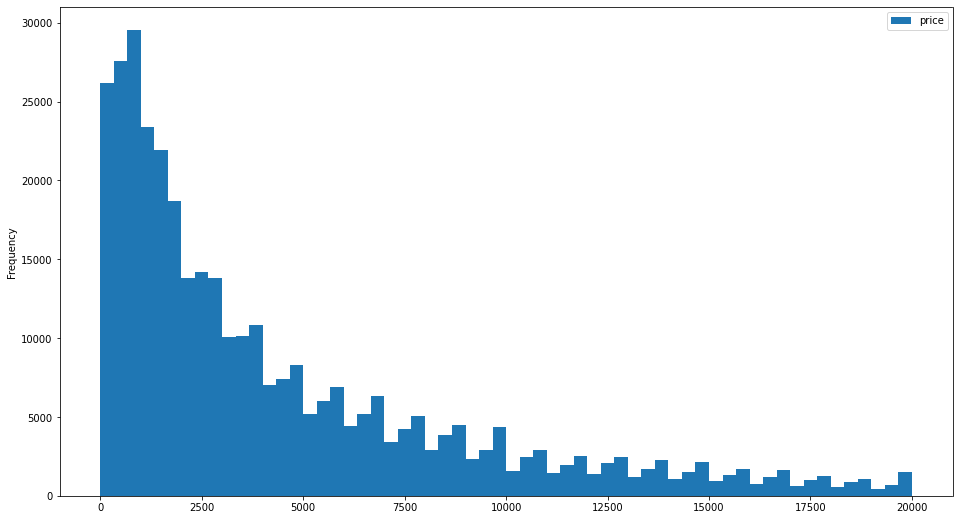

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

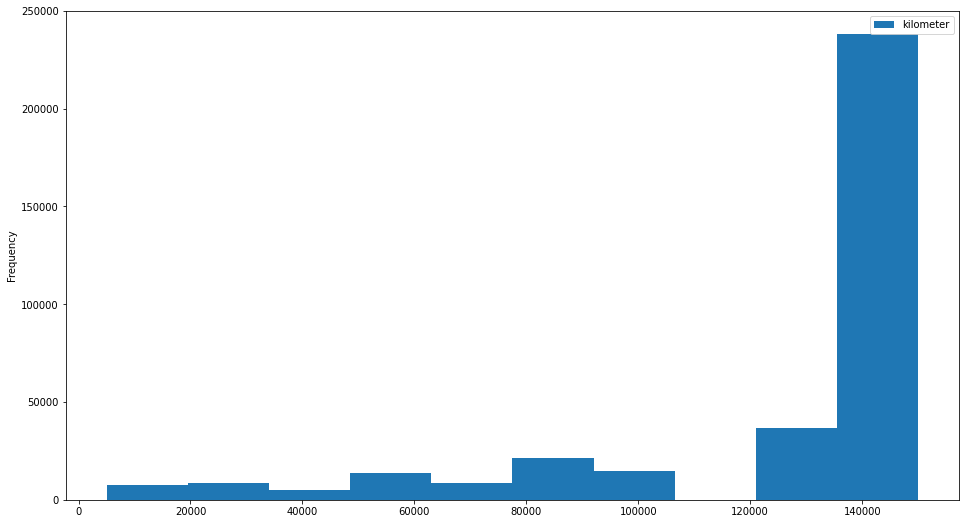

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [24]:
# выясним число автомобилей с экстремальными значениями стоимости, пробега, построим гистограммы частотности
# в выборке имеются объявления с нулевой стоимостью, в связи с чем рекомендуется уточнить эти данные у поставщика, т.к. 
# не всегда возможно предугадать условия продажи и возможности торговаться/предлагать цену
data['price'].plot.hist(bins=60, figsize=(16,9))
plt.legend()
plt.show()
display(data['price'].describe())

data['kilometer'].plot.hist(bins=10, figsize=(16,9))
plt.legend()
plt.show()
display(data['kilometer'].describe())

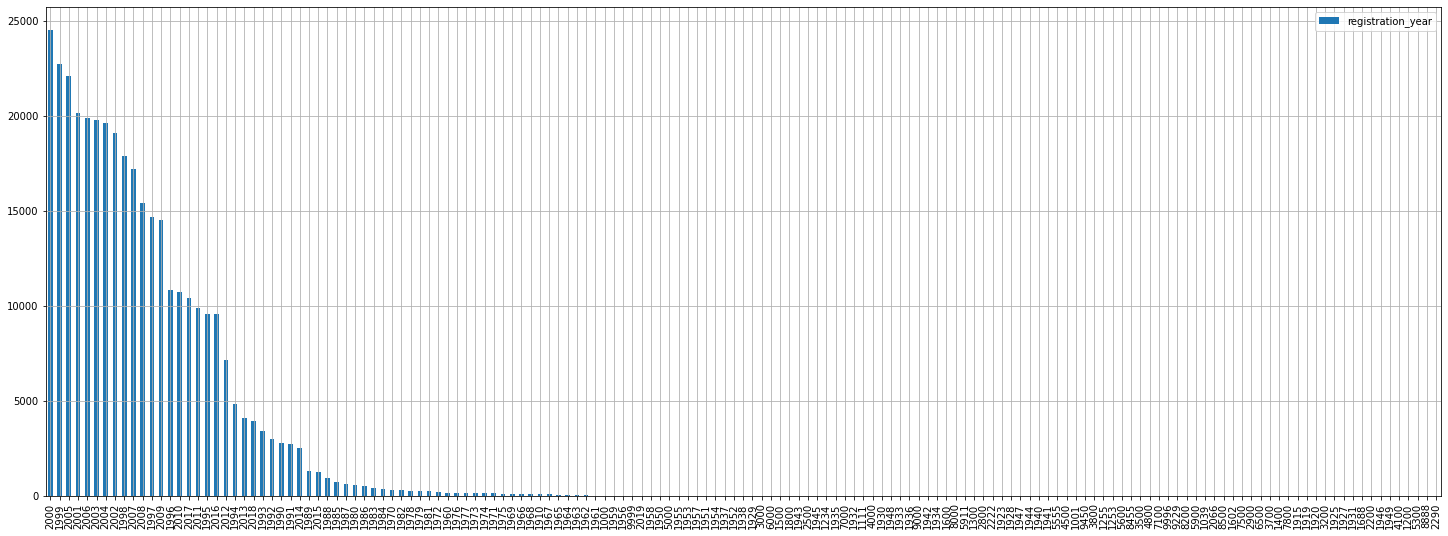

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
1987      667
1980      588
1986      538
1983      430
1984      399
1970      333
1982      316
1978      285
1979      283
1981      263
1972      213
1960      188
1976      175
1977      173
1973      173
1974      169
1971      167
1975      143
1969      118
1966      113
1968      108
1910      101
1967       99
1965       82
1964       64
1963       57
1962       46
1961       41
1000       37
1959       32
1956       27
9999       26
2019       25
1958       25
1950       18
5000       17
1955       15
1953       14
1957       13
1951  

In [25]:
# рассмотрев годы регистрации автомобилей выяснили, что присутствующие экстремумы целесообразнее удалить
# исходя из имеющихся данных следует отсечь экстремумы до 1990 года
data['registration_year'].value_counts().plot.bar(grid=True, figsize=(25,9))
plt.legend()
plt.show()
display(data['registration_year'].describe())
display(data['registration_year'].value_counts())

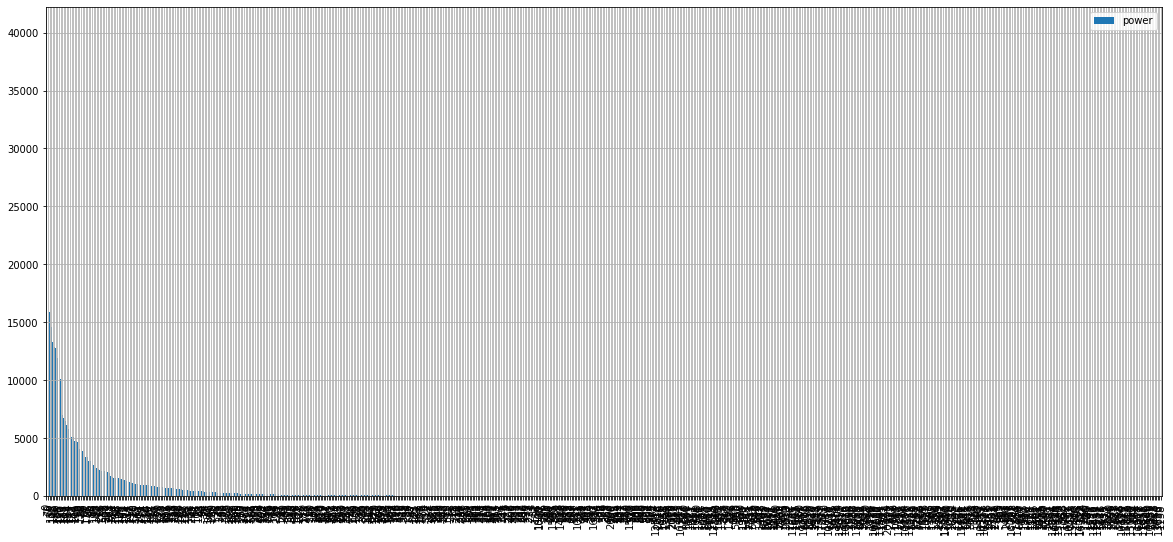

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

0        40225
75       24023
60       15897
150      14590
101      13298
140      12852
90       12734
116      11918
105      10355
170      10121
125       6965
136       6752
102       6451
163       6081
54        5745
143       5300
122       5125
131       5107
109       4777
110       4729
50        4627
80        4047
120       3875
58        3854
69        3649
177       3373
115       3323
95        3009
45        2986
68        2820
86        2702
193       2626
160       2427
82        2312
218       2252
65        2192
179       2133
55        2110
200       2041
224       2024
231       1976
204       1748
184       1622
64        1568
192       1553
88        1521
100       1509
129       1483
71        1445
190       1379
107       1361
174       1302
118       1248
147       1191
197       1138
70        1086
98        1027
145       1016
61         989
103        983
211        965
155        964
84         961
113        936
114        917
130        912
165       

In [26]:
# рассмотрев мощность автомобилей выяснили, что присутствующие экстремумы целесообразнее удалить
# исходя из имеющихся данных следует отсечь экстремумы и оставить данные со значениями более 0(у части коллекционных автомобилей ранних годов выпуска присутствуют маломощные двигатели) и менее 1000 л.с.
data['power'].value_counts().plot.bar(grid=True, figsize=(20,9))
plt.legend()
plt.show()
display(data['power'].describe())
display(data['power'].value_counts())

In [27]:
# отсечем выявленные экстремумы
marked_data = data.query('price > 0 and power > 0 and power <= 1000 and registration_year >= 1990')
display(marked_data.describe())
display(marked_data.info())

,price,registration_year,power,kilometer
count,299987.000000,299987.000000,299987.000000,299987.000000
mean,4796.304097,2004.063536,120.726601,128791.747642
std,4579.643668,32.965165,54.479281,36381.114013
min,1.000000,1990.000000,1.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,3100.000000,2004.000000,110.000000,150000.000000
75%,6900.000000,2008.000000,150.000000,150000.000000
max,20000.000000,9999.000000,1000.000000,150000.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 299987 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              299987 non-null  int64 
 1   vehicle_type       297202 non-null  object
 2   registration_year  299987 non-null  int64 
 3   gearbox            299222 non-null  object
 4   power              299987 non-null  int64 
 5   model              299987 non-null  object
 6   kilometer          299987 non-null  int64 
 7   fuel_type          296714 non-null  object
 8   brand              299987 non-null  object
 9   not_repaired       299987 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.2+ MB


None

In [28]:
# выясним оставшееся количество записей с нулевыми/отсутствующими данными - их количество в рамках выборки менее погрешности,
# поэтому целесообразно их удалить для дальнейшей обработки
display(marked_data.isna().sum())
display(marked_data.isnull().sum())

price                   0
vehicle_type         2785
registration_year       0
gearbox               765
power                   0
model                   0
kilometer               0
fuel_type            3273
brand                   0
not_repaired            0
dtype: int64

price                   0
vehicle_type         2785
registration_year       0
gearbox               765
power                   0
model                   0
kilometer               0
fuel_type            3273
brand                   0
not_repaired            0
dtype: int64

In [29]:
# удалим пропуски и проверим
marked_data.dropna(subset=['vehicle_type'], inplace=True)
marked_data = marked_data.reset_index(drop=True)
marked_data.dropna(subset=['gearbox'], inplace=True)
marked_data = marked_data.reset_index(drop=True)
marked_data.dropna(subset=['fuel_type'], inplace=True)
marked_data = marked_data.reset_index(drop=True)
display(marked_data.isna().sum())
display(marked_data.isnull().sum())
display(marked_data.info())

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246 entries, 0 to 295245
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              295246 non-null  int64 
 1   vehicle_type       295246 non-null  object
 2   registration_year  295246 non-null  int64 
 3   gearbox            295246 non-null  object
 4   power              295246 non-null  int64 
 5   model              295246 non-null  object
 6   kilometer          295246 non-null  int64 
 7   fuel_type          295246 non-null  object
 8   brand              295246 non-null  object
 9   not_repaired       295246 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


None

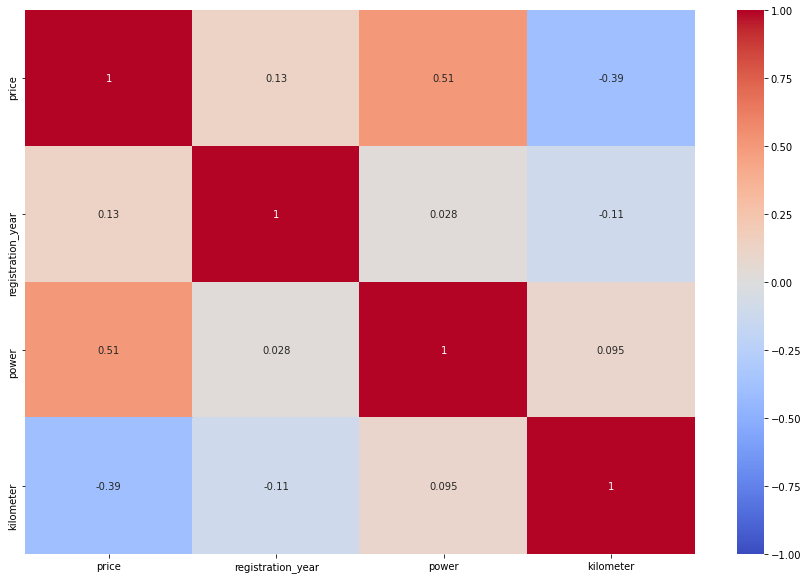

In [30]:
# рассмотрим корреляции признаков получившегося датасета по итогам предобработки данных
plt.figure(figsize=(15,10))
sns.heatmap(marked_data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

По итогам предобработки данных получился уточненный датасет, с которым далее будем работать, влияние на целевой признак несколько изменилось(корреляции возросли), при проверке корреляций выявили - мультиколлинеарности нет, влияние признаков друг на друга слабое и очень слабое, однако оно возрасло, рассмотрим динамику по признакам:
- registration_year: корреляция 0.027 - > 0.13 - очень слабая положительная, влияние признака на целевой очень слабое, корреляция возросла,
- power: корреляция 0.16 - > 0.51 - средняя положительная, влияние признака на целевой среднее, корреляция возросла,
- kilometer: корреляция -0.33 - > -0.39 - слабая отрицательная, влияние признака на целевой слабое, отрицательная корреляция незначительно возросла.

### Вывод и обзор данных

**Описание данных**

Данные находятся в файле /datasets/autos.csv.

**Признаки**

 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

**Процесс подготовки данных для работы**

    1. Получена сводная информация по датасету: 16 признаков, 295246 строк,
    2. Выявлены и исправлены недочеты:
        - наименования столбцов преобразованы в змеином стиле,
        - найдены и удалены 4 дубликата,
        - пропуски в not_repaired заполнены на неизветсные ввиду отсутствия существенной связи признака с остальными,
        - определена зависимость от признака model признака vehicle_type, gearbox, fuel_type - пропуски заполнены по наиболее часто встречающимся в конкретной модели,
        - удалены следующие признаки как не влияющие на данные модели: date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen,
        - отфильтрованы и отброшены данные с нулевой стоимостью, с регистрацией после 1990г., с мощностью более 0 и мене 1000 л.с.,
        - удалены данные с пустыми значениями в признаках: vehicle_type, gearbox, fuel_type.
    3. Преобразование данных для работы моделей:
        - следует рассмотреть возможность прямого и порядкового кодирования признаков: vehicle_type, gearbox, model, fuel_type, brand, not_repaired,
        - следует рассмотреть масштабирование признаков датасета ввиду возникновения потенциальных проблем увеличения весов части признаков.

## Обучение моделей

### Использование простых моделей

In [31]:
# подготовим признаки для простых моделей
# методом OHE
marked_data_ohe = pd.get_dummies(marked_data, columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'], 
                                 prefix=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'], drop_first=True)
display(marked_data_ohe.info())
display(marked_data_ohe.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246 entries, 0 to 295245
Columns: 307 entries, price to not_repaired_yes
dtypes: int64(4), uint8(303)
memory usage: 94.3 MB


None

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,18300,2011,190,125000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

In [32]:
# разделим выборки на целевую и основную
target = marked_data_ohe['price']
features = marked_data_ohe.drop('price', axis=1)
display(target.head(10))
display(target.shape)
display(features.head(10))
display(features.shape)

0    18300
1     9800
2     1500
3     3600
4      650
5     2200
6    14500
7      999
8     2000
9     2799
Name: price, dtype: int64

(295246,)

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,2011,190,125000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

(295246, 306)

In [33]:
# разобьем выборку на обучающую и валидационную для подбора лучших параметров моделей
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.25, random_state=654321)
display(features_train.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_valid.shape)

(221434, 306)

(73812, 306)

(221434,)

(73812,)

In [34]:
# масштабируем признаки
pd.options.mode.chained_assignment = None

numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
display('Train')
display(features_train.describe())
display(features_train.shape)
display('Valid')
display(features_valid.describe())
display(features_valid.shape)

'Train'

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
count,2.214340e+05,2.214340e+05,2.214340e+05,221434.000000,22143

(221434, 306)

'Valid'

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
count,73812.000000,73812.000000,73812.000000,73812.000000,73812.

(73812, 306)

#### Работа с LinearRegression

In [35]:
%%time
# кроссвалидация на модели LinearRegression
lr = LinearRegression()
scores = []
scores = cross_val_score(lr, features_train, target_train, cv=10, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели LinearRegression на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели LinearRegression на обучающей выборке: 2796.7213436422912
CPU times: total: 2min 4s
Wall time: 26.7 s


In [58]:
%%time
# получим RMSE для модели LinearRegression
lr.fit(features_train, target_train)
predictions_valid = lr.predict(features_valid)
print('RMSE модели LinearRegression на тестовой выборке:', math.sqrt(mean_squared_error(target_valid, predictions_valid)))

RMSE модели LinearRegression на тестовой выборке: 2802.5122084750046
CPU times: total: 14.2 s
Wall time: 2.94 s


В рамках LinearRegression применять GridSearchCV не представляется целесообразным, т.к. это базовая модель для сравнения.

#### Работа с RandomForestRegressor

In [40]:
%%time
# получим лучшие параметры для RandomForestRegressor
params = { 'n_estimators': [10, 30, 60, 80],
              'max_depth': [None, 1, 3, 10], 
         'random_state': [654321]}
rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(rfr, params, cv=5)
grid_rfr.fit(features_train, target_train)
display(grid_rfr.best_params_)

{'max_depth': None, 'n_estimators': 80, 'random_state': 654321}

CPU times: total: 1h 28min 25s
Wall time: 1h 28min 29s


In [47]:
%%time
# кроссвалидация на модели RandomForestRegressor
rfr = RandomForestRegressor(random_state=654321, n_estimators=80, max_depth=None)
scores = []
scores = cross_val_score(rfr, features_train, target_train, cv=10, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели RandomForestRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели RandomForestRegressor на обучающей выборке: 1529.7084415877148
CPU times: total: 43min 44s
Wall time: 43min 44s


In [57]:
%%time
# получим RMSE для модели RandomForestRegressor
rfr.fit(features_train, target_train)
predictions_valid = rfr.predict(features_valid)
print('RMSE модели RandomForestRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_valid, predictions_valid)))

RMSE модели RandomForestRegressor на тестовой выборке: 1536.8364176691787
CPU times: total: 5min 3s
Wall time: 5min 3s


#### Работа с DecisionTreeRegressor

In [41]:
%%time
# получим лучшие параметры для DecisionTreeRegressor
params = { 'max_features': [2, 4, 6],
              'max_depth': [None, 1, 3, 10], 
         'random_state': [654321]}
dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(dtr, params, cv=5)
grid_dtr.fit(features_train, target_train)
display(grid_dtr.best_params_)

{'max_depth': None, 'max_features': 6, 'random_state': 654321}

CPU times: total: 50.8 s
Wall time: 50.9 s


In [48]:
%%time
# кроссвалидация на модели DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=654321, max_depth=None, max_features=6)
scores = []
scores = cross_val_score(dtr, features_train, target_train, cv=10, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели DecisionTreeRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели DecisionTreeRegressor: 1970.3359155494222
CPU times: total: 18.2 s
Wall time: 18.2 s


In [56]:
%%time
# получим RMSE для модели DecisionTreeRegressor
dtr.fit(features_train, target_train)
predictions_valid = dtr.predict(features_valid)
print('RMSE модели DecisionTreeRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_valid, predictions_valid)))

RMSE модели DecisionTreeRegressor на тестовой выборке: 1942.6511654760616
CPU times: total: 1.95 s
Wall time: 1.92 s


### Использование градиентного бустинга(библиотека LightGBM)

In [53]:
%%time
# получим лучшие параметры для LGBMRegressor
params = { 'max_depth': [None, 1, 3, 10, 100],
          'n_estimators': [5, 50, 100, 150, 500],
         'random_state': [654321],
         'num_leaves': [10,30,60],
         'learning_rate':[0.05, 0.07]}
lgbmr = LGBMRegressor(objective='regression')
grid_lgbmr = GridSearchCV(lgbmr, params, cv=5)
grid_lgbmr.fit(features_train, target_train)
display(grid_lgbmr.best_params_)

{'learning_rate': 0.07,
 'max_depth': None,
 'n_estimators': 500,
 'num_leaves': 60,
 'random_state': 654321}

CPU times: total: 1h 46min 6s
Wall time: 15min 29s


In [61]:
%%time
# кроссвалидация на модели LGBMRegressor
lgbmr = LGBMRegressor(objective='regression',num_leaves=60,learning_rate=0.07,n_estimators=500, max_depth=None, random_state=654321)
scores = []
scores = cross_val_score(lgbmr, features_train, target_train, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1, error_score='raise')
print('Средняя RMSE модели LGBMRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели LGBMRegressor на обучающей выборке: 1500.249801425376
CPU times: total: 172 ms
Wall time: 24.2 s


In [55]:
%%time
# получим RMSE для модели LGBMRegressor
lgbmr.fit(features_train, target_train)
predictions_valid = lgbmr.predict(features_valid)
print('RMSE модели LGBMRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_valid, predictions_valid)))

RMSE модели LGBMRegressor на тестовой выборке: 1515.6166961073884
CPU times: total: 29.8 s
Wall time: 3.17 s


## Анализ моделей

### Сравнение характеристик моделей: скорость работы(%%time), точность результата(метрика RMSE)

In [8]:
# сформируем сводную таблицу для оценки результатов
pivot_data_models = {'Model': ['LinearRegression базовая', 'RandomForestRegressor c подобранными параметрами', 'DecisionTreeRegressor c подобранными параметрами', 'LGBMRegressor с подобранными параметрами'],
                   'RMSE cross val score на обучающей выборке': [2796.7213436422912, 1529.7084415877148, 1970.3359155494222, 1500.249801425376],
                   'Wall time CVS': ['26.7s', '43min 44s', '18.2s', '24.2s'],
                   'RMSE на тестовой выборке': [2802.5122084750046, 1536.8364176691787, 1942.6511654760616, 1515.6166961073884],
                   'Wall time test': ['2.94s', '5min 3s', '1.92s', '3.17s']}
pivot_data_models = pd.DataFrame(pivot_data_models)
display(pivot_data_models.sort_values('RMSE на тестовой выборке', ascending=True))

,Model,RMSE cross val score на обучающей выборке,Wall time CVS,RMSE на тестовой выборке,Wall time test
3,LGBMRegressor с подобранными параметрами,1500.249801,24.2s,1515.616696,3.17s
1,RandomForestRegressor c подобранными параметрами,1529.708442,43min 44s,1536.836418,5min 3s
2,DecisionTreeRegressor c подобранными параметрами,1970.335916,18.2s,1942.651165,1.92s
0,LinearRegression базовая,2796.721344,26.7s,2802.512208,2.94s


По итогам сравнения характеристик моделей по скорости работы и RMSE от наилучшей модели к наихудшей выяснили, что наименьшее и лучшее RMSE на тестовой выборке у модели LGBMRegressor с подобранными параметрами, при этом временные затраты на работу модели на уровне DecisionTreeRegressor и LinearRegression со значительно худшими параметрами RMSE(практически вдвое).